In [3]:
import os
import math
import numpy as np
import pandas as pd
import ccxt
import talib
from datetime import datetime
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from script.fetch_history_data import binance_fetch_history_price, binance_single_fetch_history_price
from script.preprocess import *
from sklearn.preprocessing import StandardScaler
from script.transformer_timestep import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Tensorflow version: 2.6.5


In [2]:
!conda install -c conda-forge ta-lib==0.4.19
!pip install seaborn
!pip install openpyxl
!pip install ccxt

#!conda install -c conda-f

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached ccxt-3.0.26-py2.py3-none-any.whl (3.5 MB)
  Using cached aiodns-3.0.0-py3-none-any.whl (5.0 kB)
  Using cached cryptography-39.0.2-cp36-abi3-win_amd64.whl (2.5 MB)
  Using cached aiohttp-3.8.4-cp38-cp38-win_amd64.whl (324 kB)
  Using cached yarl-1.8.2-cp38-cp38-win_amd64.whl (56 kB)
  Using cached pycares-4.3.0-cp38-cp38-win_amd64.whl (76 kB)
  Using cached multidict-6.0.4-cp38-cp38-win_amd64.whl (28 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached frozenlist-1.3.3-cp38-cp38-win_amd64.whl (34 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached charset_normalizer-3.1.0-cp38-cp38-win_amd64.whl (96 kB)


In [4]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
valid_percent = 20
test_percent = 10

target_column='Close_MA_ptc_10'
pearson_corr_cutoff = 0.2

# with open('multi_factor_v2.0.1.pickle', 'rb') as input_pickle:
#     multi_factor_dic = pickle.load(input_pickle)

# zscore_col = multi_factor_dic['zscore'][0]
# zscore_std = multi_factor_dic['zscore'][1]
# zscore_mean = multi_factor_dic['zscore'][2]
# input_col = multi_factor_dic['input_col']

In [5]:
def calculate_z_score_input_format(df_cal):
    for col in zscore_col:
        df_cal[col] = (df_cal[col] - zscore_mean) / zscore_std
    return df_cal[input_col], df_cal

In [8]:
df = binance_fetch_history_price(coin='BTC/USDT', timeframe='1h', start_date='2019-09-10')
timeframes = [10,20,40,60,80,100,120,140,160,180,200]
df_cal = calculate_technical_indicators(df, timeframes=timeframes)
df_train, df_val, df_test = preprocess_train_test_split(df_cal, valid_percent=valid_percent, test_percent=test_percent)
df_cal.to_pickle('./data/multi_factor_v2.0.2.pickle')

In [5]:
# 'UpperBB_10', 'MiddleBB_10','LowerBB_10','UpperMAE_10','MiddleMAE_10','LowerMAE_10',

In [9]:
df_cal = pd.read_pickle('./data/multi_factor_v2.0.2.pickle')
df_train, df_val, df_test = preprocess_train_test_split(df_cal, valid_percent=valid_percent, test_percent=test_percent)
df_cal_drop_col = df_train.copy()
#del df_cal_drop_col['Timestamp']
ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
ma_ptc_col += ['ZhangDieFu', 'ZhenFu']	
zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()

for col in ma_ptc_col:
    df_cal_drop_col[col] = (df_cal_drop_col[col] - zscore_mean) / zscore_std

# pearson corr filter
filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]
minmax_df = df_cal_drop_col[filterd_col]

# save z-score to dictionary
multi_factor_dic = {}
multi_factor_dic['zscore'] = [ma_ptc_col, zscore_std, zscore_mean]
multi_factor_dic['input_col'] = filterd_col

# with open('multi_factor_v2.0.2.pickle', 'wb') as input_pickle:
#     pickle.dump(multi_factor_dic, input_pickle)

In [5]:
with open('multi_factor_v2.0.2.pickle', 'rb') as input_pickle:
    multi_factor_dic = pickle.load(input_pickle)

zscore_col = multi_factor_dic['zscore'][0]
zscore_std = multi_factor_dic['zscore'][1]
zscore_mean = multi_factor_dic['zscore'][2]
input_col = multi_factor_dic['input_col']

In [6]:
df_train_zscore, df_train_zscore_total = calculate_z_score_input_format(df_train)
df_val_zscore, df_val_zscore_total = calculate_z_score_input_format(df_val)
df_test_zscore, df_test_zscore_total = calculate_z_score_input_format(df_test)

In [7]:
X_train, y_train = preprocess_sequence_data(df_train_zscore, target_column=target_column, seq_len=seq_len)
X_val, y_val = preprocess_sequence_data(df_val_zscore, target_column=target_column, seq_len=seq_len)
X_test, y_test = preprocess_sequence_data(df_test_zscore, target_column=target_column, seq_len=seq_len)

In [ ]:
# for build z score dictionary

# df = pd.read_pickle('./data/multi_factor_v2.0.1.pickle')
# df_cal_drop_col = df.copy()
# del df_cal_drop_col['Timestamp']
# ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
# ma_ptc_col += ['ZhangDieFu', 'ZhenFu']
# zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
# zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()

# for col in ma_ptc_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - zscore_mean) / zscore_std
# # pearson corr filter
# filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]

# multi_factor_dic = {}
# multi_factor_dic['zscore'] = [ma_ptc_col, zscore_std, zscore_mean]
# multi_factor_dic['input_col'] = filterd_col

# with open('multi_factor_v2.0.1.pickle', 'wb') as input_pickle:
#     pickle.dump(multi_factor_dic, input_pickle)

In [ ]:
# df_train, df_val, df_test = preprocess_train_test_split(minmax_df, valid_percent=valid_percent, test_percent=test_percent)
# X_train, y_train = preprocess_sequence_data(df_train, target_column=target_column, seq_len=seq_len)
# X_val, y_val = preprocess_sequence_data(df_val, target_column=target_column, seq_len=seq_len)
# X_test, y_test = preprocess_sequence_data(df_test, target_column=target_column, seq_len=seq_len)

In [11]:
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=in_seq, outputs=out)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,
                                                                decay_steps=10000,
                                                                decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./model_weight/transformer_btc_multi_factor_v2.0.2.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

2023-03-19 06:27:40.882174: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 06:27:41.654329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44773 MB memory:  -> device: 0, name: NVIDIA Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 94)]    0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 96)      0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 96)      1238848     concatenate[0][0]            

In [58]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=15, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/15
861/861 [==============================] - 608s 686ms/step - loss: 0.2011 - mae: 0.2994 - mape: 286.0630 - val_loss: 0.1084 - val_mae: 0.2217 - val_mape: 482.2097

Epoch 00001: val_loss did not improve from 0.10740
Epoch 2/15
861/861 [==============================] - 588s 683ms/step - loss: 0.1944 - mae: 0.2941 - mape: 292.0310 - val_loss: 0.1080 - val_mae: 0.2209 - val_mape: 263.7799

Epoch 00002: val_loss did not improve from 0.10740
Epoch 3/15
861/861 [==============================] - 590s 685ms/step - loss: 0.1885 - mae: 0.2870 - mape: 274.7966 - val_loss: 0.1061 - val_mae: 0.2281 - val_mape: 456.6451

Epoch 00003: val_loss improved from 0.10740 to 0.10609, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.2.hdf5
Epoch 4/15
861/861 [==============================] - 591s 686ms/step - loss: 0.1836 - mae: 0.2866 - mape: 307.3154 - val_loss: 0.1039 - val_mae: 0.2169 - val_mape: 570.2629

Epoch 00004: val_loss improved from 0.10609 to 0.10391, saving model t

In [8]:
model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_v2.0.2.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

test_pred  = model.predict(X_test)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

2023-03-20 12:14:40.035253: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 12:14:40.818041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44773 MB memory:  -> device: 0, name: NVIDIA Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5
2023-03-20 12:14:46.519723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-20 12:14:52.770666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


Test Data - Loss: 0.0712, MAE: 0.1868


In [ ]:
# #zscore = (x - mean) / std
# def restore_zscore_close_price(df, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128):
#     input_df = df.copy()
#     # restore min mnax
#     input_df[target_col][seq_len:] = input_df[target_col][seq_len:]*zscore_std + zscore_mean
#     restored_close_list = []
#     for idx in range(seq_len, len(input_df)):
#         previois_avg     = input_df.loc[idx - moving_avg_step : idx - 1 ,'Close'].mean()
#         close_avg        = previois_avg * (input_df[target_col][idx] + 1)
#         restored_close   = (close_avg * moving_avg_step) - (input_df.loc[idx - (moving_avg_step -1) : idx - 1, 'Close'].sum())
#         restored_close_list.append(restored_close)
#     input_df['pred_Close'] = '-'
#     input_df['pred_Close'][seq_len:] = restored_close_list
#     return input_df


#zscore = (x - mean) / std
# def restore_zscore_close_price_v2(pred_df, all_col_df, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128):
#     # copy close, close_MA_10, to pred_df
#     input_df = pred_df.copy()
#     input_df_all_columns = all_col_df.copy()
#     input_df['Close'] = input_df_all_columns['Close'][input_df.index]
#     input_df['Close_MA_10'] = input_df_all_columns['Close_MA_10'][input_df.index]
    
#     # restore min mnax
#     input_df = input_df.reset_index(drop=True)
#     input_df[target_col][seq_len:] = input_df[target_col][seq_len:]*zscore_std + zscore_mean
#     restored_close_list = []
#     for idx in range(seq_len, len(input_df)):
#         previois_avg     = input_df['Close_MA_10'][idx-1]
#         close_avg        = previois_avg * (input_df[target_col][idx] + 1)
#         restored_close   = (close_avg * moving_avg_step) - (input_df.loc[idx - (moving_avg_step -1) : idx - 1, 'Close'].sum())
#         restored_close_list.append(restored_close)
#     input_df['pred_Close'] = '-'
#     input_df['pred_Close'][seq_len:] = restored_close_list
#     print(len(restored_close_list))
#     return input_df, restored_close_list

In [ ]:
# test_pred.flatten().shape

In [ ]:
# df_zscore['pred_Close_MA_ptc_10'] = '-'
# df_zscore['pred_Close_MA_ptc_10'][seq_len:] = test_pred.flatten()
# df_output, price_list = restore_zscore_close_price_v2(df_zscore, df_zscore_total, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128)

In [ ]:
# test_pred
# single_input_df = pd.DataFrame(X_test[0], columns=list(df_zscore.columns))
# single_input_df.tail(10)

In [50]:
y_test[0]

-0.5052621639361341

In [9]:
def validation_restore_close(test_pred, df_zscore_total, seq_len=128):
    df_zscore_output = df_zscore_total.reset_index(drop=True).copy()
    df_zscore_output['pred_Close']='-'
    # 128~len(df)
    for i in range(seq_len, len(df_zscore_output)):
        # restore the model predicted_ptc
        pred_ptc = test_pred[i-seq_len]*zscore_std + zscore_mean
        # choose the single_df[0:128] (index 0~127) 
        single_df = df_zscore_output[i-seq_len:i]
        # take the final MA_10
        pre_MA = single_df['Close_MA_10'][single_df.index[-1]]
        # final MA_10* pred_ptc = pred_MA10
        close_MA = pre_MA*(pred_ptc+1)
        # pred_MA_10*10 - pre 9 Close = pred_Close
        pred_close = close_MA*10 - single_df['Close'][-9:].sum()
        df_zscore_output['pred_Close'][i] = pred_close
    return df_zscore_output

def restore_zscore_close_price_v3(test_pred, df_zscore_total, seq_len=128):
    df_zscore_output = df_zscore_total.reset_index(drop=True).copy()
    df_zscore_output['pred_Close']='-'
    # 128~len(df)
    for i in range(seq_len, len(df_zscore_output)):
        # restore the model predicted_ptc
        pred_ptc = test_pred[i-seq_len][0]*zscore_std + zscore_mean
        # choose the single_df[0:128] (index 0~127) 
        single_df = df_zscore_output[i-seq_len:i]
        # take the final MA_10
        pre_MA = single_df['Close_MA_10'][single_df.index[-1]]
        # final MA_10* pred_ptc = pred_MA10
        close_MA = pre_MA*(pred_ptc+1)
        # pred_MA_10*10 - pre 9 Close = pred_Close
        pred_close = close_MA*10 - single_df['Close'][-9:].sum()
        df_zscore_output['pred_Close'][i] = pred_close
    return df_zscore_output

In [10]:
df_output = restore_zscore_close_price_v3(test_pred, df_test_zscore_total, seq_len=128)

In [53]:
test = validation_restore_close(y_test, df_test_zscore_total, seq_len=128)

In [11]:
restored_df = df_output.copy()

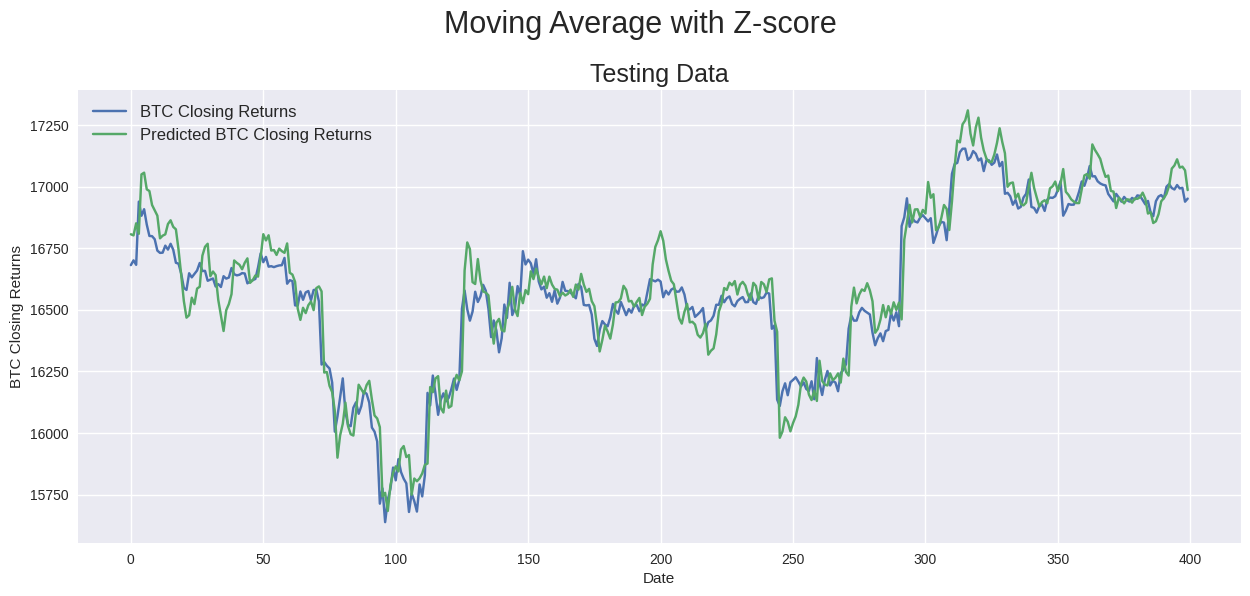

In [13]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
seq_len = 128
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with Z-score", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(restored_df['Close'][seq_len:seq_len+400].values, label='BTC Closing Returns')
ax11.plot(restored_df['pred_Close'][seq_len:seq_len+400].values, label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

In [46]:
def calculate_trading_returns(df, leverage, input_amount, fee_rate):
    balance_final = input_amount
    position = 0  # 0表示沒有持倉，1表示持多倉，-1表示持空倉
    initial_price = df.iloc[0]['Close']
    fee = 0  # 手續費

    for i in range(1, len(df)):
        prev_close = df.iloc[i-1]['Close']
        curr_close = df.iloc[i]['Close']
        pred_close = df.iloc[i]['pred_Close']

        if position == 0:  # 如果沒有持倉
            if pred_close > curr_close:  # 如果預測收盤價比當前收盤價高，則做多
                position = 1
                price = curr_close
            else:  # 否則做空
                position = -1
                price = curr_close
        elif position == 1:  # 如果持多倉
            if pred_close < curr_close:  # 如果預測收盤價比當前收盤價低，則平倉
                position = 0
                price = curr_close
                fee = input_amount * fee_rate
                profit = (price - initial_price) / initial_price * input_amount * leverage - fee
                balance_final = balance_final + profit
                print(f'Close long position: balance_final={balance_final:.2f}')
                print()
            else:  # 否則繼續持倉
                price = curr_close
        elif position == -1:  # 如果持空倉
            if pred_close > curr_close:  # 如果預測收盤價比當前收盤價高，則平倉
                position = 0
                price = curr_close
                fee = input_amount * fee_rate
                profit = (initial_price - price) / initial_price * input_amount * leverage - fee
                balance_final = balance_final + profit
                print(f'Close long position: balance_final={balance_final:.2f}')
            else:  # 否則繼續持倉
                price = curr_close
    if position != 0:  # 如果還有未平倉的持倉，則強制平倉
        if position == 1:
            direction = 'long'
        else:
            direction = 'short'
        price = curr_close
        fee = input_amount * fee_rate
        profit = (price - initial_price) / initial_price * input_amount * leverage - fee
        balance_final = balance_final + profit
        print(f'Force close {direction} position: balance_final={balance_final:.2f}')

In [18]:
df_output.tail()

,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200,pred_Close
3068,26926.2,26998.8,26815.9,26963.4,19803.686,27058.70,27162.37,26952.89,27036.19,18653.4489,-0.611460,-0.544942,-0.519331,-0.395331,0.045260,11.976829,-19.369539,241.581577,-66.666667,-0.006206,0.406682,2.367969,40.315231,-0.003930,-7.668162,46.599898,-54.268061,27234.234287,27036.19,26838.145713,17.580624,32.204329,27234.234287,27036.19,26838.145713,-1819951.555,27213.335,27326.130,27043.655,27189.515,27816.21805,-0.446685,-0.406372,-0.421539,-0.411467,0.007610,0.069648,281.656521,-66.666667,50.034824,-0.005646,27555.467818,27189.515,26823.562182,27555.467818,27189.515,26823.562182,27175.6675,27320.9600,27013.0075,27189.4375,32373.185025,0.121524,0.064832,0.102472,0.089586,-0.024465,12.836931,307.873326,-66.666667,56.418465,0.000538,27763.012246,27189.4375,26615.862754,27763.012246,27189.4375,26615.862754,26704.138333,26875.260000,26549.983333,26737.763333,38166.618300,0.391498,0.317940,0.369729,0.362322,-0.015502,16.300450,312.322282,66.666667,58.150225,0.011627,28291.316790,26737.763333,25184.209877,28291.316790,26737.763333,25184.209877,26174.94750,26338.89375,26031.59875,26208.38625,36672.132162,0.350197,0.346

In [49]:
calculate_trading_returns(restored_df[seq_len:].reset_index(drop=True), leverage=2, input_amount=10000, fee_rate=0)


Close long position: balance_final=9865.49

Close long position: balance_final=9768.39

Close long position: balance_final=9572.98

Close long position: balance_final=9706.77
Close long position: balance_final=9519.51

Close long position: balance_final=9509.68
Close long position: balance_final=9816.10

Close long position: balance_final=9772.34

Close long position: balance_final=9803.51
Close long position: balance_final=9708.69

Close long position: balance_final=9755.32
Close long position: balance_final=9673.56

Close long position: balance_final=9659.17

Close long position: balance_final=9647.31
Close long position: balance_final=9448.42

Close long position: balance_final=9569.50
Close long position: balance_final=9095.61

Close long position: balance_final=9908.17
Close long position: balance_final=10625.07
Close long position: balance_final=11350.84
Close long position: balance_final=10733.08

Close long position: balance_final=9644.31

Close long position: balance_final=850

In [21]:
df_output_pred

,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200,pred_Close,actual_daily_return,actual_return,transaction_cost,pred_return,pred_transaction_cost
128,16691.3,16734.4,16672.0,16683.0,10126.343,16568.49,16653.56,16529.75,16594.36,16187.6183,0.372492,0.291134,0.595764,0.472306,-0.129647,-1.426524,9.213580,133.259143,66.666667,-0.268564,-0.274310,1.260965,54.606790,0.003294,-35.160907,-53.273733,18.112826,16727.610237,16594.36,16461.109763,68.350106,68.724128,16727.610237,16594.36,16461.109763,-5168106.622,16641.830,16703.530,16564.410,16630.380,24357.78120,-0.320768,-0.325133,-0.307512,-0.343126,0.001907,0.028338,149.589724,66.666667,50.014169,0.002061,16863.540036,16630.380,16397.219964,16863.540036,16630.380,16397.219964,16761.5575,16832.5500,16679.5175,16758.9150,25033.013425,-0.212913,-0.208055,-0.123895,-0.150836,-0.018920,-1.801265,173.502651,-66.666667,49.099367,-0.000037,17082.884074,16758.9150,16434.945926,17082.884074,16758.9150,16434.945926,16710.303333,16793.658333,16623.503333,16709.733333,25604.638950,-0.138714,-0.257166,-0.028649,-0.106111,-0.066798,-4.034395,191.011920,-66.666667,47.982803,-0.001069,17074.065377,16709.733333,16345.401289,17074.065377,16709.733333,